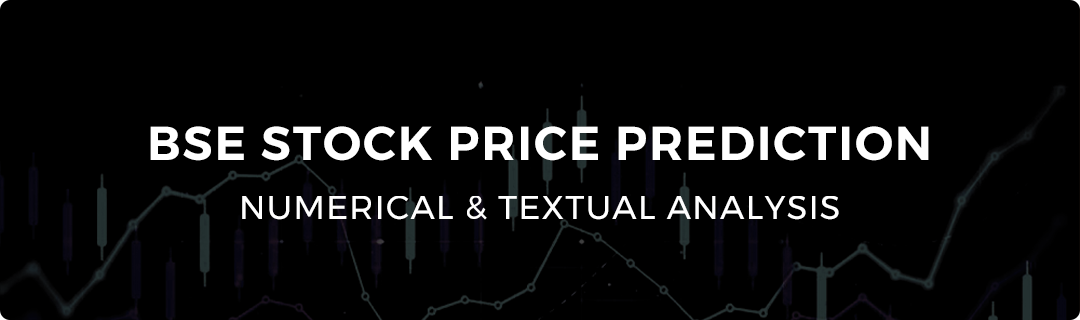

## 1. INTRODUCTION
**Sensex** is the benchmark index of India's Bombay Stock Exchange (BSE). It is made up of 30 of the largest and most actively traded stocks on the BSE and serves as a key indicator of the India's economy.  Established in 1986, it is India’s oldest stock index and it is managed by Standard & Poor's (S&P). Analysts and investors use it to track the cycles of the Indian economy as well as the growth and decline of specific companies. **[Reference](https://www.investopedia.com/terms/s/sensex.asp)**

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">1.1. PROBLEM DEFINITION/GOAL</h4>

The goal of this notebook is to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines! 

I will split the notebook into two parts. In the first part, I will use the **Long Short-Term Memory (LSTM) model** to do a quick stock price prediction of the `bse` stock. In the second part of the notebook, I will combine the findings from the textual analysis to create a **hybrid model**.

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">1.2. DATA SOURCE</h4>

The original data is the Bombay Stock Exchange data, made available by **[yahoo finance](https://finance.yahoo.com/quote/%5EBSESN/history?p=%5EBSESN)**. Since I was only interested in analyzing a 5-year historical data from `2017-03-31` to `2022-03-31`, I set the start and end date and imported it with `yfinance`.

The textual (news) datasetis an ongoing historical record of major occurrences in India from the beginning of 2001 to the first quarter of 2022. It was published by **[HARVARD Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH)**. 

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">1.3. FEATURES</h4>

Feature List: `Date`, `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`, `Subjectivity`, `Polarity`, `Compound`, `Neu (Neutral)`, `Pos (Positive)`, and `Neg (Negative)`.

**Data Dictionary:**

* **Date:** The day, month, and year in which the stock was traded.<br>
* **Open:**  The price at which a stock first trades upon the opening of an exchange on a trading day.<br>
* **High:** This refers to a stock's highest trading price for the day.<br>
* **Low:** This is the lowest price at which a stock trades in that day.<br>
* **Close:** This is the last price at which a stock trades during a a particular day.<br>
* **Adj Close:** This is the closing price after all applicable splits and dividend distributions have been taken into account.<br>
* **Volume:** The total number of shares that were exchanged in a specific stock, index, or other investment during a particular time frame.<br>
* **Subjectivity:** The degree to which a person opinion is personally involved in an object.<br>
* **Polarity:** The strength of an opinion which could either be positive or negative.<br>
* **Compound:** The normalizes compound score which calculates the sum of all lexicon ratings.<br>
* **Neu (Neutral):** The probability of a sentiment to be neutral.<br>
* **Pos (Positive):** The probability of a sentiment to be positive.<br>
* **Neg (Negative):** The probability of a sentiment to be negative.


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">1.4. IMPORTING LIBRARIES</h4>

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import datetime as dt

import plotly.graph_objects as go
import plotly.express as px

from itertools import cycle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
%matplotlib inline

In [27]:
!pip install yfinance

In [28]:
#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">1.5. LOADING THE TRAINING DATASET</h4>

In total, I will be working with a 5-year historical BSE data from `2017-03-31` to `2022-03-31`. For the training dataset, I will only load the first 4 years, that is from `2017-03-31` to `2021-03-31`. This is the data I will use to train my model. The last one year data will be used to test my model. I purposely chose this time frame, so it tallies with my textual data.

In [29]:
import yfinance as yf
# Dataset for Training
dataset_train = yf.download('^BSESN', start='2017-03-31', end='2022-03-31')

[*********************100%***********************]  1 of 1 completed


## 2. EXPLORATORY DATA ANALYSIS (EDA)

Let's get a better understanding of our data by viewing the details and making some comparison.

**EDA CHECKLIST**

* View the data details<br>
* View qualitative measures of the data<br>
* Check for missing values<br>
* Normalize the data<br>
* Visualize the data by creating time series graph and bar charts.<br>
* Checking to see if there's something that needs to be added, changed, or removed to get more out of the data.

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">2.1. VIEWING THE DETAILS</h4>

In [30]:
dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,29620.500000,11800
2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,29910.220703,10100
2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,29974.240234,11200
2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,29927.339844,11300
2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,29706.609375,14700


In [31]:
dataset_train.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [32]:
train = dataset_train.reset_index() # Set Index to Column

In [33]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,29706.609375,14700


In [34]:
# Drop the Adj Close columm 

train = train.drop(['Adj Close'], axis=1)
train.head()

,Date,Open,High,Low,Close,Volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">2.2. CHECKING FOR MISSING VALUES</h4>

In [35]:
print("Null values:", train.isnull().values.sum())
print("NA values:", train.isna().values.any())

Null values: 0
NA values: False


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1230 non-null   datetime64[ns]
 1   Open    1230 non-null   float64       
 2   High    1230 non-null   float64       
 3   Low     1230 non-null   float64       
 4   Close   1230 non-null   float64       
 5   Volume  1230 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 57.8 KB


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">2.3. COMPARISON BETWEEN STOCK OPEN AND CLOSE PRICE</h4>

In [37]:
comp_opclo= train.groupby(train['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
comp_opclo = comp_opclo.reindex(new_order, axis=0)
comp_opclo

,Open,Close
Date,,
January,43822.606243,43736.500295
February,44178.418170,44139.626369
March,42014.234902,41945.353457
April,36608.487253,36589.690049
May,36897.209229,36841.106389
June,38656.903720,38622.399442
July,39299.276705,39251.322212
August,40166.430852,40141.940017
September,41029.013208,40939.386835


In [38]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=comp_opclo.index,
    y=comp_opclo['Open'],
    name='Stock Open Price',
    marker_color='#0b1d78'
))
fig.add_trace(go.Bar(
    x=comp_opclo.index,
    y=comp_opclo['Close'],
    name='Stock Close Price',
    marker_color='#1fe074'
))

fig.update_layout(barmode='group', xaxis_tickangle=-90, 
                  title='Comparision Between Stock Open and Close price')
fig.show()

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">2.4. COMPARISON BETWEEN STOCK HIGH AND LOW PRICE</h4>

In [39]:
comp_hilo= train.groupby(train['Date'].dt.strftime('%B'))[['High','Low']].mean()
comp_hilo = comp_hilo.reindex(new_order, axis=0)
comp_hilo

,High,Low
Date,,
January,43985.268573,43495.127101
February,44444.491342,43838.929969
March,42361.915254,41507.621035
April,36830.159272,36335.377118
May,37087.644644,36631.618690
June,38835.759821,38412.482515
July,39433.386275,39073.743821
August,40333.597149,39929.038386
September,41199.985071,40714.108505


In [40]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=comp_hilo.index,
    y=comp_hilo['High'],
    name='Stock High Price',
    marker_color='#0b1d78'
))
fig.add_trace(go.Bar(
    x=comp_hilo.index,
    y=comp_hilo['Low'],
    name='Stock Low Price',
    marker_color='#1fe074'
))

fig.update_layout(barmode='group', xaxis_tickangle=-90, 
                  title='Comparision Between Stock High and Low Price')
fig.show()

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">2.5. TREND COMPARISON BETWEEN OPEN, CLOSE, HIGH, & LOW PRICES</h4>

In [41]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(train, x=train.Date, y=[train['Open'], train['Close'], 
                                          train['High'], train['Low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## 3. MODELING

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.1. TRAINING OUR MODEL WITH THE STOCK OPEN PRICE</h4>

In [42]:
train_set = train.iloc[:, 1:2].values

**NORMALIZATION**<br>
Let's import MinMaxScaler from scikit-learn to Normalize the train dataset.

In [43]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.2. CREATING X_TRAIN AND Y_TRAIN DATA STRUCTURES</h4>

In order to use our LSTM model, we need our data in the form of a 3D array. First, we need to create data in 60 timesteps and then use NumPy to convert it to an array. 

In [44]:
X_train = []
y_train = []
for i in range(60, 983):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(923, 60)
(923,)


In [45]:
# Reshape the Data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(923, 60, 1)

**IMPORTING MORE LIBRARIES**

In [46]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.3. MODEL BUILDING - LSTM</h4>

In [47]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50,return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50,return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1))

In [48]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

**FITTING THE MODEL**

In [49]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

lstm_model.fit(X_train,y_train,epochs=100,batch_size=50)

Epoch 1/100
19/19 [==============================] - 28s 139ms/step - loss: 0.0267
Epoch 2/100
19/19 [==============================] - 3s 162ms/step - loss: 0.0069
Epoch 3/100
19/19 [==============================] - 3s 154ms/step - loss: 0.0031
Epoch 4/100
19/19 [==============================] - 4s 187ms/step - loss: 0.0031
Epoch 5/100
19/19 [==============================] - 3s 134ms/step - loss: 0.0030
Epoch 6/100
19/19 [==============================] - 3s 146ms/step - loss: 0.0028
Epoch 7/100
19/19 [==============================] - 3s 132ms/step - loss: 0.0029
Epoch 8/100
19/19 [==============================] - 2s 130ms/step - loss: 0.0033
Epoch 9/100
19/19 [==============================] - 4s 201ms/step - loss: 0.0029
Epoch 10/100
19/19 [==============================] - 3s 156ms/step - loss: 0.0031
Epoch 11/100
19/19 [==============================] - 3s 168ms/step - loss: 0.0024
Epoch 12/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0023
Epoch 13/100

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.4. EXTRACTING THE TEST DATASET</h4>

Let's load our unseen test set for predictions. For this, I will import the dataset from `2021-04-01` to `2022-03-31`, which is approximately 20% of the data.

In [50]:
# Dataset for Testing
dataset_test = yf.download('^BSESN', start='2021-04-01', end='2022-03-31')

[*********************100%***********************]  1 of 1 completed


Before making predictions, we need to apply the same changes we made to the train dataset to the test data set.

In [51]:
dataset_test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-01,49868.531250,50092.480469,49478.531250,50029.828125,50029.828125,8500
2021-04-05,50020.910156,50028.671875,48580.800781,49159.320312,49159.320312,12700
2021-04-06,49441.128906,49582.261719,48936.351562,49201.390625,49201.390625,9600
2021-04-07,49277.089844,49900.128906,49093.898438,49661.761719,49661.761719,9800
2021-04-08,49885.261719,50118.078125,49581.609375,49746.210938,49746.210938,21800


In [52]:
dataset_test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [53]:
test = dataset_test.reset_index() # Set Index to Column

In [54]:
test = test.drop(['Adj Close'], axis=1)
test.head()

,Date,Open,High,Low,Close,Volume
0,2021-04-01,49868.531250,50092.480469,49478.531250,50029.828125,8500
1,2021-04-05,50020.910156,50028.671875,48580.800781,49159.320312,12700
2,2021-04-06,49441.128906,49582.261719,48936.351562,49201.390625,9600
3,2021-04-07,49277.089844,49900.128906,49093.898438,49661.761719,9800
4,2021-04-08,49885.261719,50118.078125,49581.609375,49746.210938,21800


In [55]:
test_set = test.iloc[:, 1:2].values

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.5. PREPARING THE INPUT DATA</h4>

We must make some changes to the training set before making future stock price predictions. To achieve this, we will start by merging the training set and the test set on the 0-axis, set the time step to 30, utilize the minmaxscaler, and reshape the dataset as before. 

In [56]:
# Prepping the input for the model
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 300):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.6. PREDICTING STOCK VALUES FROM 2021-04-01 TO 2022-03-31</h4>

In [57]:
predicted_bse_stock_price = lstm_model.predict(X_test)
predicted_bse_stock_price = sc.inverse_transform(predicted_bse_stock_price)

8/8 [==============================] - 3s 33ms/step


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">3.6. PLOTTING THE ACTUAL AND PREDICTED STOCK PRICES FOR BSE STOCK</h4>

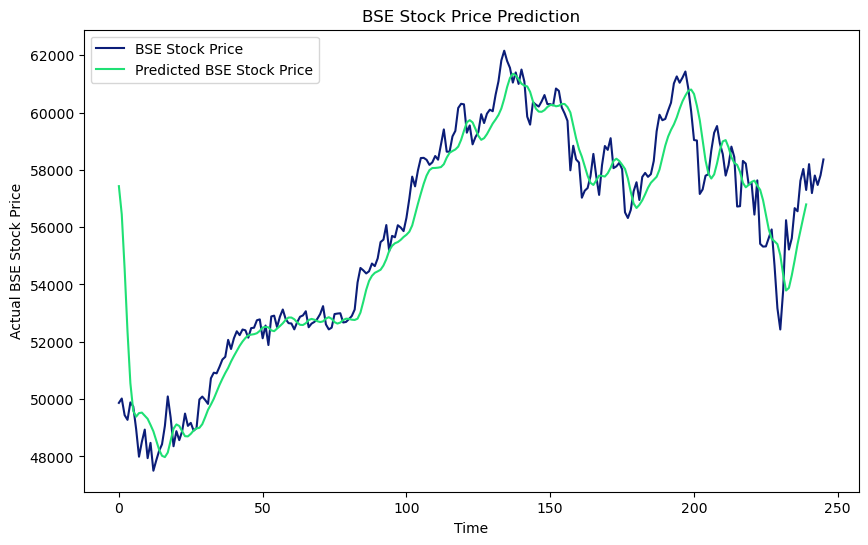

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(test_set, color = '#0b1d78', label = 'BSE Stock Price')
plt.plot(predicted_bse_stock_price, color = '#1fe074', label = 'Predicted BSE Stock Price')
plt.title('BSE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual BSE Stock Price')
plt.legend()
plt.show()

## 4. SENTIMENT ANALYSIS OF NEWS HEADLINES

Sentiment analysis can help us in interpreting public sentiment and emotions as well as obtaining useful context-specific data. It is the process of assessing data and categorizing them in accordance with the requirements of the study. [Reference](https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524).

Inthis notebook, we will use one of python's library for natural language processing (NLP), TextBlob to conduct a sentiment analysis. My goal is to try to predict if BSE stock price will increase or decrease based on the top news headline.

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.1. IMPORT LIBRARIES</h4>

In [59]:
!pip install vaderSentiment

     -------------------------------------- 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [60]:
from textblob import TextBlob
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.corpus import stopwords
from textblob import Word

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.2. LOADING TEXTUAL DATA</h4>

In [62]:
indf = pd.read_csv("C:/Users/Tejus/Downloads/india-news-headlines.csv")

In [63]:
indf.head(10)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
5,20010102,unknown,Dilute the power of transfers; says Riberio
6,20010102,unknown,Focus shifts to teaching of Hindi
7,20010102,unknown,IT will become compulsory in schools
8,20010102,unknown,Move to stop freedom fighters' pension flayed
9,20010102,unknown,Gilani claims he applied for passport 2 years ago


In [64]:
indf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [65]:
# Let's make some changes to the data
# Convert the publish_date to datetime data type

indf['publish_date'] = pd.to_datetime(indf['publish_date'], 
                                      format = '%Y%m%d')

In [66]:
indf.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [67]:
indf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [68]:
# Drop the headline_category column

indf = indf.drop(['headline_category'], axis=1)
indf.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


In [69]:
# Change column names

indf = indf.rename(columns={'publish_date':'date','headline_text': 'headline'})
indf.head()

,date,headline
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


Let's slice the data so that it matches our train data.

In [70]:
start_date = pd.to_datetime('2017-03-31')
end_date = pd.to_datetime('2021-03-31')
indf = indf.loc[(indf['date'] >= start_date) & (indf['date'] <= end_date)]

In [71]:
# Reset Index
indf = indf.reset_index()
indf = indf.drop('index', axis=1)
indf.head

<bound method NDFrame.head of              date                                           headline
0      2017-03-31  Nookalamma festival ushers in Ugadi for north ...
1      2017-03-31             Calangute still awaits sewerage system
2      2017-03-31  India Open Super Series 2017: PV Sindhu v Sain...
3      2017-03-31                   Ali Asgar plays an Adivasi woman
4      2017-03-31  diya aur baati hum actor anas rashid i met her...
...           ...                                                ...
856833 2021-03-31   Fire in Safdarjung ICU ward; 50 patients shifted
856834 2021-03-31  Rape case can't be quashed even after 'pact': ...
856835 2021-03-31         Complete work in industrial areas; says CM
856836 2021-03-31                      No funds; DUTA plans protests
856837 2021-03-31        Many civic services in EDMC areas go online

[856838 rows x 2 columns]>

In [72]:
# Let's drop duplicates
indf['headline'] = indf.groupby(['date']).transform(lambda x: ' '.join(x))
indf = indf.drop_duplicates()
indf.reset_index(inplace = True, drop = True)

In [73]:
indf.head()

,date,headline
0,2017-03-31,Nookalamma festival ushers in Ugadi for north ...
1,2017-04-01,Are you an obsessive lover? 10 fragrance hacks...
2,2017-04-02,Two arrested with cannabis in J&K What's your ...
3,2017-04-03,Lalu Prasad demands probe into EVM malfunction...
4,2017-04-04,RBI failed to implement demonetisation properl...


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.3. MERGING STOCK DATA AND TEXTUAL DATA </h4>

Now we're going to merge both the textual data and the stock data on the `date` column, but before we do that, let's first rename the `train` columns so it has the same naming convention as our textual data.

In [74]:
train_new = train.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low',
                         'Close': 'close', 'Volume': 'volume'})

train_new.head()

,date,open,high,low,close,volume
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700


Now we will merge both data on the date field.

In [75]:
bse_merge = pd.merge(train_new, indf, how='inner', on='date')
bse_merge

,date,open,high,low,close,volume,headline
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,Nookalamma festival ushers in Ugadi for north ...
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,Lalu Prasad demands probe into EVM malfunction...
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,Bagaha hospital: Nothing changed in last 43 ye...
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,Whenever I thought I should quit; a good film ...
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,10 erotic books dirtier than Fifty Shades of G...
...,...,...,...,...,...,...,...
979,2021-03-24,49786.468750,49854.578125,49120.339844,49180.308594,9200,No rights violations in Nov 2015 protests Sams...
980,2021-03-25,49201.980469,49247.949219,48236.351562,48440.121094,14300,Overconfidence of coalitions in Kerala Meet Be...
981,2021-03-26,48969.250000,49234.660156,48699.910156,49008.500000,10600,Numerology Today; 26 March 2021: Read predicti...
982,2021-03-30,49331.679688,50268.449219,49331.679688,50136.578125,10500,Three Fantastic ways OPPO F19 Pro+ 5G; will re...


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.4. DATA PRE-PROCESSING</h4>

**CLEAN TEXT DATA**<br>
This is to ensure that our data is in the form that our machine will understand. So we will remove the texts and characters that are irrelevant.

In [76]:
# Case Conversion
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [77]:
# Numbers
bse_merge['headline'] = bse_merge['headline'].str.replace('\d','')

In [78]:
# Punctuations
bse_merge['headline'] = bse_merge['headline'].str.replace('[^\w\s]','')

In [80]:
 import nltk

 nltk.download()
sw = stopwords.words('english')
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(
    x for x in x.split() if x not in sw))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [81]:
# Deletion of sparse terms which can can cause over-fitting
remove = pd.Series(' '.join(bse_merge['headline']).split()).value_counts()[-1000:]
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ". join(x for x in x.split() 
                                                              if x not in remove))

In [82]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tejus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [83]:
bse_merge['headline'] = bse_merge['headline'].apply(lambda x: " ".join(
    [Word(word).lemmatize() for word in x.split()]))

In [84]:
bse_merge.head()

,date,open,high,low,close,volume,headline
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...


In [85]:
bse_merge['headline'][0:15]

0     nookalamma festival usher ugadi north coastal ...
1     lalu prasad demand probe evm malfunctioning ar...
2     bagaha hospital nothing changed last year firm...
3     whenever thought quit good film came way aishw...
4     erotic book dirtier fifty shade grey temple pr...
5     sakhavu puthan panam superhero comic movie mar...
6     watch hair tan summer fertility could directly...
7     natural way lighten dark underarms rakshit she...
8     top banned book india shakespeare meet kathaka...
9     sex leave broken rib review dove lament anthol...
10    dog bite case daily pkula civil hospital raaga...
11    jeweller get year jail term disclosing swiss b...
12    mercedes benz q sale co say highest ever okhad...
13    pay park moneyspinner smc dont show anger sath...
14    reversing diabetes take hold expert call susta...
Name: headline, dtype: object

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.3. DEFINING FUNCTIONS TO GET SUBJECTIVITY AND POLARITY</h4>

`Polarity` falls between -1 and 1, where -1 defines a negative sentiment and 1 defines a positive sentiment.

`Subjectivity` on the other hand quantifies the amount of personal opinion and factual information contained in the text. The higher the subjectivity, the more the personal opinion and the less the factual information.

In [86]:
# Get subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Get polarity:

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [87]:
bse_merge['subjectivity'] = bse_merge['headline'].apply(get_subjectivity)
bse_merge['polarity'] = bse_merge['headline'].apply(get_polarity)

In [88]:
bse_merge.head()

,date,open,high,low,close,volume,headline,subjectivity,polarity
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...,0.396482,0.040100
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...,0.422808,0.054991
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...,0.377483,0.046132
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...,0.406224,0.033153
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...,0.384157,0.069506


**DENSITY PLOT OF POLARITY**

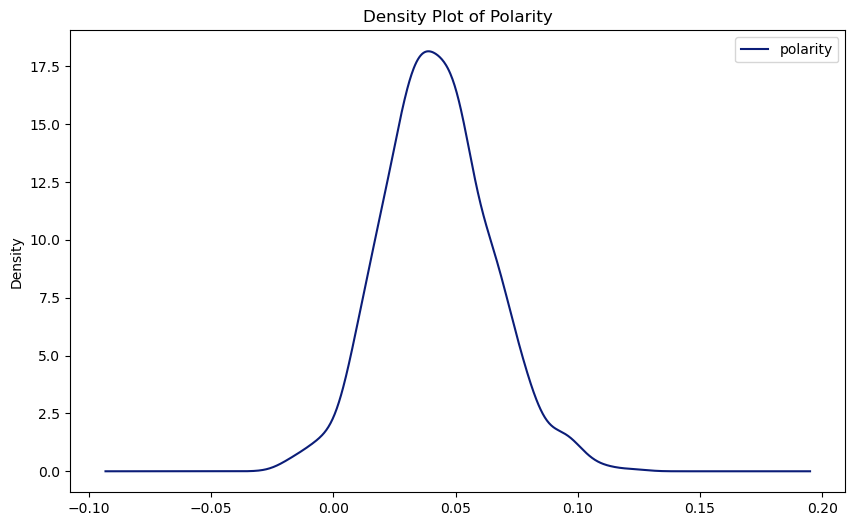

In [89]:
pd.DataFrame(bse_merge['polarity']).plot(kind='density', figsize=(10, 6), 
                             color=['#0b1d78'])

plt.title("Density Plot of Polarity")
plt.show()

**DENSITY PLOT OF SUBJECTIVITY**

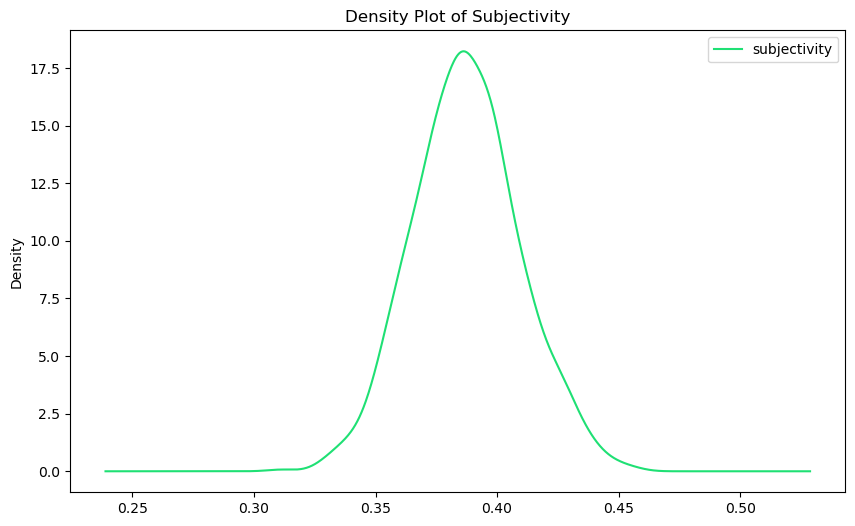

In [90]:
pd.DataFrame(bse_merge['subjectivity']).plot(kind='density', figsize=(10, 6), 
                             color=['#1fe074'])

plt.title("Density Plot of Subjectivity")
plt.show()

Looking at the density plot for the `polarity` and `subjectivity`, we can see that there is a normal distribution of the values.

<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.4. SENTIMENT SCORES</h4>

Now let's define the functions to get the sentiment score.

In [91]:
# create function to get the sentiment score:

def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

In [92]:
# get Sentiment score for each day:
compound=[]
neg=[]
pos=[]
neu=[]
SIA=0

for i in range (0, len(bse_merge['headline'])):
    SIA= getSIA(bse_merge['headline'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])

In [93]:
bse_merge['compound']= compound
bse_merge['neg']= neg
bse_merge['pos']=pos
bse_merge['neu']=neu

bse_merge.head()

,date,open,high,low,close,volume,headline,subjectivity,polarity,compound,neg,pos,neu
0,2017-03-31,29633.910156,29687.640625,29552.609375,29620.500000,11800,nookalamma festival usher ugadi north coastal ...,0.396482,0.040100,-0.9998,0.159,0.118,0.723
1,2017-04-03,29737.730469,29926.939453,29705.720703,29910.220703,10100,lalu prasad demand probe evm malfunctioning ar...,0.422808,0.054991,-0.9999,0.168,0.108,0.724
2,2017-04-05,29996.029297,30007.480469,29817.689453,29974.240234,11200,bagaha hospital nothing changed last year firm...,0.377483,0.046132,-0.9999,0.166,0.110,0.725
3,2017-04-06,29946.890625,29954.250000,29817.589844,29927.339844,11300,whenever thought quit good film came way aishw...,0.406224,0.033153,-0.9998,0.155,0.105,0.740
4,2017-04-07,29850.710938,29886.119141,29668.449219,29706.609375,14700,erotic book dirtier fifty shade grey temple pr...,0.384157,0.069506,-0.9999,0.177,0.105,0.718


Let's create a new dataframe that contains the features we need.

In [94]:
df = bse_merge[['close', 'subjectivity', 
                'polarity', 'compound', 'neg', 'pos', 'neu']]

df.head()

,close,subjectivity,polarity,compound,neg,pos,neu
0,29620.500000,0.396482,0.040100,-0.9998,0.159,0.118,0.723
1,29910.220703,0.422808,0.054991,-0.9999,0.168,0.108,0.724
2,29974.240234,0.377483,0.046132,-0.9999,0.166,0.110,0.725
3,29927.339844,0.406224,0.033153,-0.9998,0.155,0.105,0.740
4,29706.609375,0.384157,0.069506,-0.9999,0.177,0.105,0.718


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.5. FEATURE SCALING - MINMAXSCALER</h4>

In [95]:
sc2 = MinMaxScaler()
df_scaled = pd.DataFrame(sc2.fit_transform(df))
df_scaled.columns = df.columns
df_scaled.index = df.index
df_scaled.head()

,close,subjectivity,polarity,compound,neg,pos,neu
0,0.139047,0.587320,0.424981,0.00010,0.421053,0.569767,0.430108
1,0.150116,0.768974,0.528345,0.00005,0.515789,0.453488,0.440860
2,0.152562,0.456223,0.466852,0.00005,0.494737,0.476744,0.451613
3,0.150771,0.654542,0.376755,0.00010,0.378947,0.418605,0.612903
4,0.142337,0.502274,0.629098,0.00005,0.610526,0.418605,0.376344


<h4 style="background-color:black;color:white;border-radius: 8px; padding:12px">4.6. CREATE HYBRID MODEL</h4>

We will try and predict the stock close price based on the sentiment scores. So the dependent variable will be the `close` price, and the independent variables will be the `subjectivity`, `polarity`, `compound`, `neg`, `pos`, and `neu`.

In [96]:
X = df_scaled.drop("close", axis=1) # drop close column
y = df_scaled["close"] # only the close column

Next we'll split our data into a training and test set using sklearn train test split.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
!pip install catboost

     ---------------------------------------- 74.0/74.0 MB 8.5 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00


**CATBOOST REGRESSOR**<br>
I chose this model because it does a really good job at incorporating many data types, such images, audio, or text elements, into one framework.

In [99]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor(iterations = 200,
                      learning_rate = 0.1,
                      depth = 5)
cb.fit(X_train, y_train)
y_pred_cat = cb.predict(X_test)

0:	learn: 0.1910041	total: 146ms	remaining: 29s
1:	learn: 0.1894067	total: 148ms	remaining: 14.6s
2:	learn: 0.1882902	total: 149ms	remaining: 9.76s
3:	learn: 0.1869903	total: 149ms	remaining: 7.32s
4:	learn: 0.1849765	total: 150ms	remaining: 5.85s
5:	learn: 0.1839795	total: 151ms	remaining: 4.87s
6:	learn: 0.1830141	total: 151ms	remaining: 4.17s
7:	learn: 0.1822074	total: 152ms	remaining: 3.65s
8:	learn: 0.1806654	total: 153ms	remaining: 3.25s
9:	learn: 0.1799346	total: 154ms	remaining: 2.92s
10:	learn: 0.1789658	total: 155ms	remaining: 2.66s
11:	learn: 0.1779180	total: 156ms	remaining: 2.44s
12:	learn: 0.1772374	total: 156ms	remaining: 2.25s
13:	learn: 0.1765087	total: 157ms	remaining: 2.09s
14:	learn: 0.1760007	total: 158ms	remaining: 1.95s
15:	learn: 0.1752729	total: 158ms	remaining: 1.82s
16:	learn: 0.1748778	total: 159ms	remaining: 1.72s
17:	learn: 0.1736348	total: 160ms	remaining: 1.62s
18:	learn: 0.1729956	total: 161ms	remaining: 1.53s
19:	learn: 0.1726894	total: 162ms	remaining

In [100]:
mse_cb = metrics.mean_squared_error(y_test, y_pred_cat)
rmse_cb = np.sqrt(mse_cb)

print("RMSE for CatBoost Model: ",rmse_cb)

RMSE for CatBoost Model:  0.164828818113276


**RANDOM FOREST REGRESSOR**<br>
Let's also try with the RandomForestRegressor.

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)

mse_rf = metrics.mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("RMSE for Random Forest Model: ", rmse_rf)

RMSE for Random Forest Model:  0.16775411371603624


## 5. CONCLUSION
In this notebook, we have tried to create a hybrid model for stock price performance using numerical analysis of historical stock prices and sentimental analysis of news headlines. In the first part of the notebook, the **Long Short-Term Memory (LSTM) model** was used to do a quick stock price prediction of the `bse` stock. And then in the second part, two models `CatBoost Regressor` and `RandomForest Regressor` were used to find patterns in our data and `Root Mean Squared Error (RMSE)` was used for evaluation.<br>

RMSE is a square root of value obtained from the mean square error function which helps us to see the difference between the predicted and the actual value. Looking at the RMSE score for both models, we can see that the CatBoost Model did a better job at predicting the BSE Stock close price.<br>

You are all welcomed to copy and make improvements and adustments were necessary. **Thanks for reading!!!**